Mean Income: $74,278.74
Median Income: $51,226.93
Skewness: 4.9499
Pearson's Skewness: 0.7361
Fraction of households below the mean: 66.00%

Log Upper Bound: 5.5
Mean Income: $68,116.70
Median Income: $51,226.93
Skewness: 1.6377
Fraction Below Mean: 62.18%

Log Upper Bound: 6.0
Mean Income: $74,278.74
Median Income: $51,226.93
Skewness: 4.9499
Fraction Below Mean: 66.00%

Log Upper Bound: 6.5
Mean Income: $88,703.43
Median Income: $51,226.93
Skewness: 9.1085
Fraction Below Mean: 73.54%


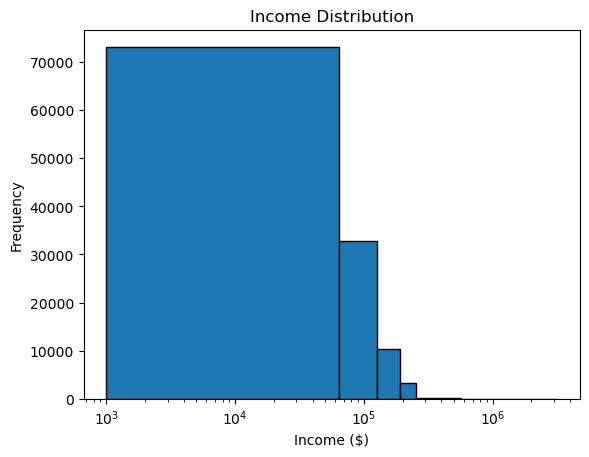

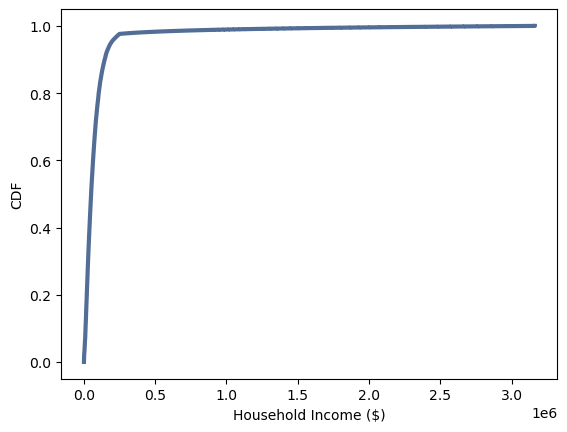

<Figure size 800x600 with 0 Axes>

In [95]:
# Assignment 5.2
# Georgette Joseph
# 01/08/2025


import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import thinkstats2
import thinkplot

# Load the dataset and select the relevant columns
# The dataset contains income ranges and the number of respondents in each range.
data = pd.read_csv('hinc06.csv', skiprows=8)
data = data.iloc[:, [0, 1]]  # Select only the first two columns
data.columns = ['income', 'freq']  # Rename columns for clarity

# Extract the upper bound of each income range
def extract_upper_bound(value):
    if "Under" in value:
        return 5000  # Handle the "Under $5,000" case
    elif "or more" in value or "and over" in value:
        return 250000  # Handle the "$250,000 or more" case
    elif "to" in value:
        # Extract the upper bound from ranges like "$5,000 to $9,999"
        return int(value.split("to")[-1].replace("$", "").replace(",", "").strip())
    else:
        return None  # Handle unexpected formats gracefully

# Apply the function to clean the income column
data['income'] = data['income'].apply(extract_upper_bound)

# Clean the freq column: remove commas and convert to integers
data['freq'] = data['freq'].str.replace(',', '').astype(int)

# Function to generate a pseudo-sample of household incomes
# Interpolates data within income ranges based on a log10 scale
def InterpolateSample(df, log_upper):
    df = df.copy()  # Avoid modifying the original DataFrame
    df['log_upper'] = np.log10(df['income'])  # Calculate the log10 upper bound
    df['log_lower'] = df['log_upper'].shift(1, fill_value=3.0)  # Set log10 lower bound
    df.loc[df.index[-1], 'log_upper'] = log_upper  # Adjust the last upper bound

    # Create arrays of interpolated values for each income range
    arrays = [np.linspace(row['log_lower'], row['log_upper'], int(row['freq'])) for _, row in df.iterrows()]
    return np.concatenate(arrays)

# Generate the pseudo-sample with the default upper bound of log10(1,000,000)
log_upper = 6.0
log_sample = InterpolateSample(data, log_upper=log_upper)
income_sample = 10**log_sample  # Convert back to original income scale

# Calculate mean, median, skewness
mean_income = income_sample.mean()
median_income = np.median(income_sample)
sample_skewness = skew(income_sample)
std_income = income_sample.std()

# Calculate Pearson's skewness
pearson_skewness = 3 * (mean_income - median_income) / std_income

# Calculate the fraction of households below the mean income
fraction_below_mean = (income_sample < mean_income).sum() / len(income_sample)

# Print the calculated statistics
print(f"Mean Income: ${mean_income:,.2f}")
print(f"Median Income: ${median_income:,.2f}")
print(f"Skewness: {sample_skewness:.4f}")
print(f"Pearson's Skewness: {pearson_skewness:.4f}")
print(f"Fraction of households below the mean: {fraction_below_mean:.2%}")

# Analyze the dependence of results on the assumed upper bound
upper_bounds = [5.5, 6.0, 6.5]  # Different log10 upper bounds for the highest range
results = []

# Compute statistics for each upper bound
for bound in upper_bounds:
    log_sample = InterpolateSample(data, log_upper=bound)
    income_sample = 10**log_sample
    results.append({
        "log_upper": bound,
        "mean": income_sample.mean(),
        "median": np.median(income_sample),
        "skewness": skew(income_sample),
        "fraction_below_mean": (income_sample < income_sample.mean()).sum() / len(income_sample)
    })

# Print the results for different upper bounds
for result in results:
    print(f"\nLog Upper Bound: {result['log_upper']}")
    print(f"Mean Income: ${result['mean']:,.2f}")
    print(f"Median Income: ${result['median']:,.2f}")
    print(f"Skewness: {result['skewness']:.4f}")
    print(f"Fraction Below Mean: {result['fraction_below_mean']:.2%}")

# Plot the histogram of income distribution
plt.hist(income_sample, bins=50, edgecolor='k')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel("Income ($)")
plt.ylabel("Frequency")
plt.title("Income Distribution")
plt.show()

# Plot the cumulative distribution function (CDF)
cdf = thinkstats2.Cdf(income_sample)
thinkplot.Cdf(cdf)
thinkplot.Show(xlabel="Household Income ($)", ylabel="CDF")

